In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
import lightgbm as lgbm

import gc

### Dataset Description

General Categories:

* D_* : Deliquency variables
* S_* : Spend variables
* P_* : Payment variables
* B_* : Balance varibles
* R_* : Risk variables

Categorical Variables: 
    B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_117, D_120, D_126


In [3]:
train = pd.read_feather("./dataset/train_data.ftr")
test = pd.read_feather("./dataset/test_data.ftr")

In [4]:
with pd.option_context("display.min_rows", 4):
    display(train)
    display(test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,0
5531450,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-03-14,0.981934,0.002474,0.000077,0.992676,0.000809,0.119141,0.003286,0.014091,...,NaN,NaN,0.007317,0.002888,0.006207,NaN,0.005112,0.003183,0.001914,0


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363760,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-03-19,0.460449,0.002663,0.009529,0.816406,0.009026,NaN,0.008530,0.006851,...,NaN,NaN,NaN,0.007195,0.008453,0.004776,NaN,0.006199,0.005604,0.005970
11363761,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-04-18,0.454590,0.004402,0.000346,0.810059,0.008736,NaN,0.000937,0.003494,...,NaN,NaN,NaN,0.003399,0.009590,0.006187,NaN,0.007675,0.006443,0.003143


In [5]:
# Creating list of the categorical columns for later usage
categoricalCols = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_117', 'D_120', 'D_126']

In [6]:
# Reformatting the training and testing dataframes to replace index column with customer ID
train = train.groupby("customer_ID").tail(1).set_index("customer_ID")
test = test.groupby("customer_ID").tail(1).set_index("customer_ID")

In [7]:
# Examining the shape of training and testing data
print(f"There are {train.shape[0]} rows and {train.shape[1]} columns in the training data")
print(f"There are {test.shape[0]} rows and {test.shape[1]} columns in the testing data\n")

# Examining the time period from which the data was collected
print(f"Training data period began \
{train.S_2.min().strftime('%m-%d-%Y')} and ended {train.S_2.max().strftime('%m-%d-%Y')}")
print(f"Testing data period began \
{test.S_2.min().strftime('%m-%d-%Y')} and ended {test.S_2.max().strftime('%m-%d-%Y')}")

# Observing if there are any empty values within the S_2 data period
if not train.S_2.isna().any():
    print("\nThere are no empty values in the training set during period S_2")
else:
    print("\nThere are empty values in the training set during period S_2 ")

if not test.S_2.isna().any():
    print("There are no empty values in the test set during period S_2")
else:
    print("There are empty values in the test set during period S_2 ")

There are 458913 rows and 190 columns in the training data
There are 924621 rows and 189 columns in the testing data

Training data period began 03-01-2018 and ended 03-31-2018
Testing data period began 04-01-2019 and ended 10-31-2019

There are no empty values in the training set during period S_2
There are no empty values in the test set during period S_2


In [8]:
# Examining feature distribution across the various categories
deliquencyTotal = [x for x in train.columns if x.startswith('D_')]
spendTotal = [x for x in train.columns if x.startswith('S_')]
paymentTotal = [x for x in train.columns if x.startswith('P_')]
balanceTotal = [x for x in train.columns if x.startswith('B_')]
riskTotal = [x for x in train.columns if x.startswith('R_')]

In [9]:
# Collecting values to be used for graphing

labels = ['Deliquency', 'Spend', 'Payment', 'Balance', 'Risk']
values = [len(deliquencyTotal), len(spendTotal), len(paymentTotal), len(balanceTotal), len(riskTotal)]

# Creating a pie chart to examination breakdown 
fig1 = go.Figure()
fig1.add_trace(go.Pie(values=values, labels=labels, hole=0.5,
                        hoverinfo='label+percent',
                        showlegend=False,
                        textinfo='label',
                        title='Category Distribution'))

fig1.show()


In [10]:
# Observing how much of the data is missing across all of the columns by percentage
nullTotal = train.isna().sum().div(len(train)).mul(100).sort_values(ascending=False)

In [11]:
# Creating plot for null data
fig3 = make_subplots(rows=2, cols=1)
fig3.add_trace(go.Bar(
    x=nullTotal[:100].index,
    y=nullTotal[:100].values,
    marker_color='rgb(26, 118, 109)'),
    row=1, col=1
)

fig3.add_trace(go.Bar(
    x=nullTotal[100:].index,
    y=nullTotal[100:].values,
    marker_color='rgb(26, 118, 109)'),
    row=2, col=1
)

fig3.update_layout(
    title="Percentage of Missing Data Per Column",
    xaxis_tickfont_size=8,
    showlegend=False
)
fig3.update_yaxes(title_text="Percentage (%)", row=1, col=1)
fig3.update_yaxes(title_text="Percentage (%)", row=2, col=1)
fig3.show()

In [12]:
targetCount = train.target.value_counts()
targetCount.rename(index={1:'Default',0:'Paid'},inplace=True)
fig2 = go.Figure()
fig2.add_trace(go.Pie(values=targetCount,
                            labels=targetCount.index,
                            hole=0.5,
                            hoverinfo='label+percent',
                            showlegend=False,
                            title='Target Distribution'))



## Exploring Each Variable

/var/folders/l0/6nnd3xcj65d77cy7d4xft29h0000gn/T/ipykernel_74488/404379609.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 1.0, 'Correlation Between Spend Variables\n')

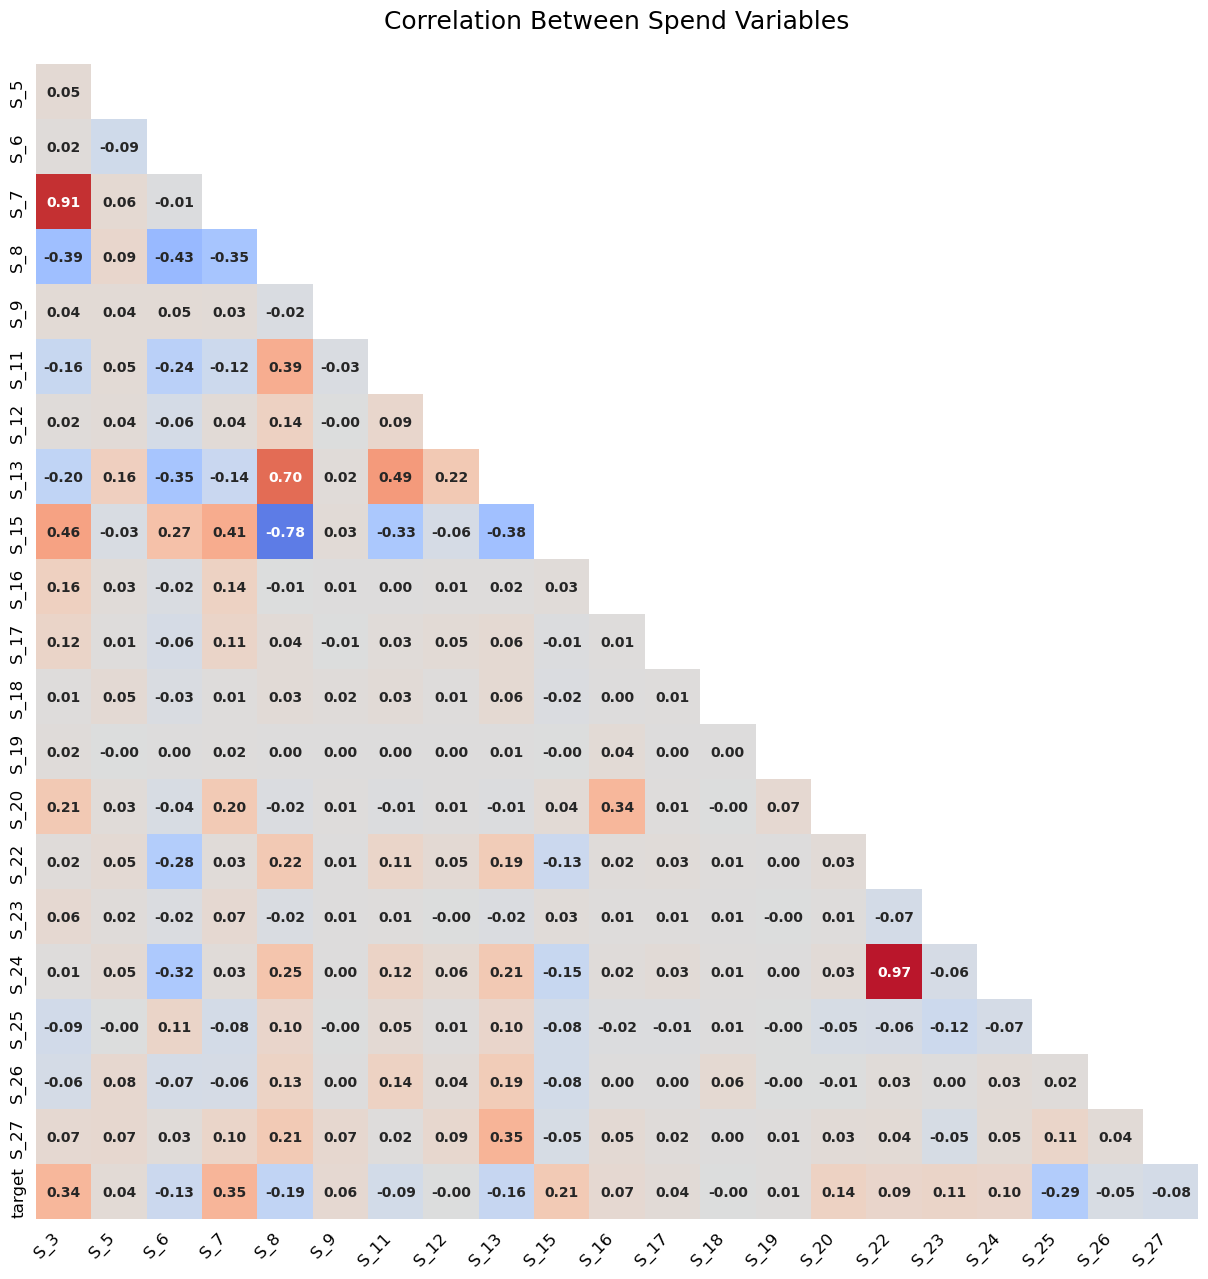

In [31]:
# Code modified from http://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols = [col for col in train.columns if (col.startswith(('S', 't'))) & (col not in categoricalCols)]
corr = train[cols].corr()
mask = np.triu(np.ones_like(corr))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt=".2f",
            cmap='coolwarm', annot_kws={"fontsize" : 10, "fontweight": "bold"}, cbar=False)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlation Between Spend Variables\n', fontsize=18)

Text(0.5, 1.0, 'Correlation Between Payment Variables\n')

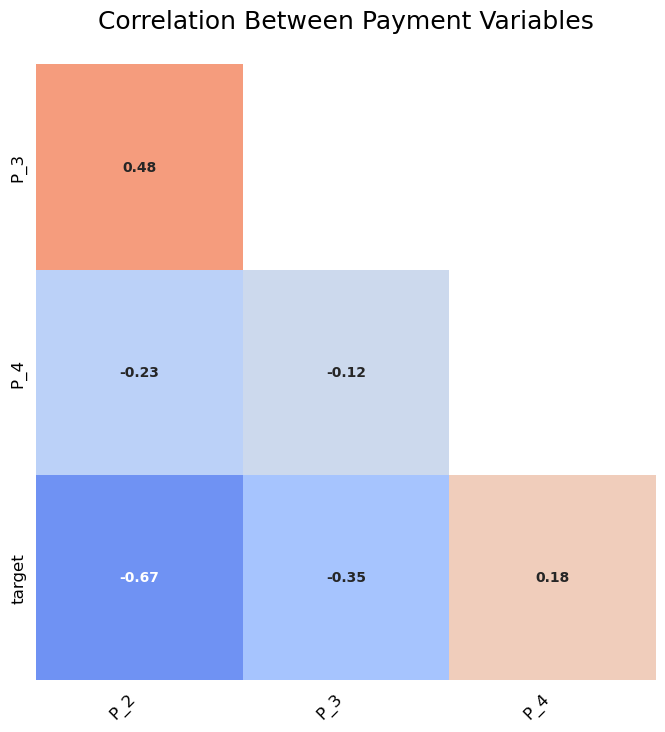

In [34]:
# Code modified from http://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols = [col for col in train.columns if (col.startswith(('P','t'))) & (col not in categoricalCols)]
corr = train[cols].corr()
mask = np.triu(np.ones_like(corr))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt=".2f",
            cmap='coolwarm', annot_kws={"fontsize" : 10, "fontweight": "bold"}, cbar=False)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlation Between Payment Variables\n', fontsize=18)

Text(0.5, 1.0, 'Correlation Between Balance Variables\n')

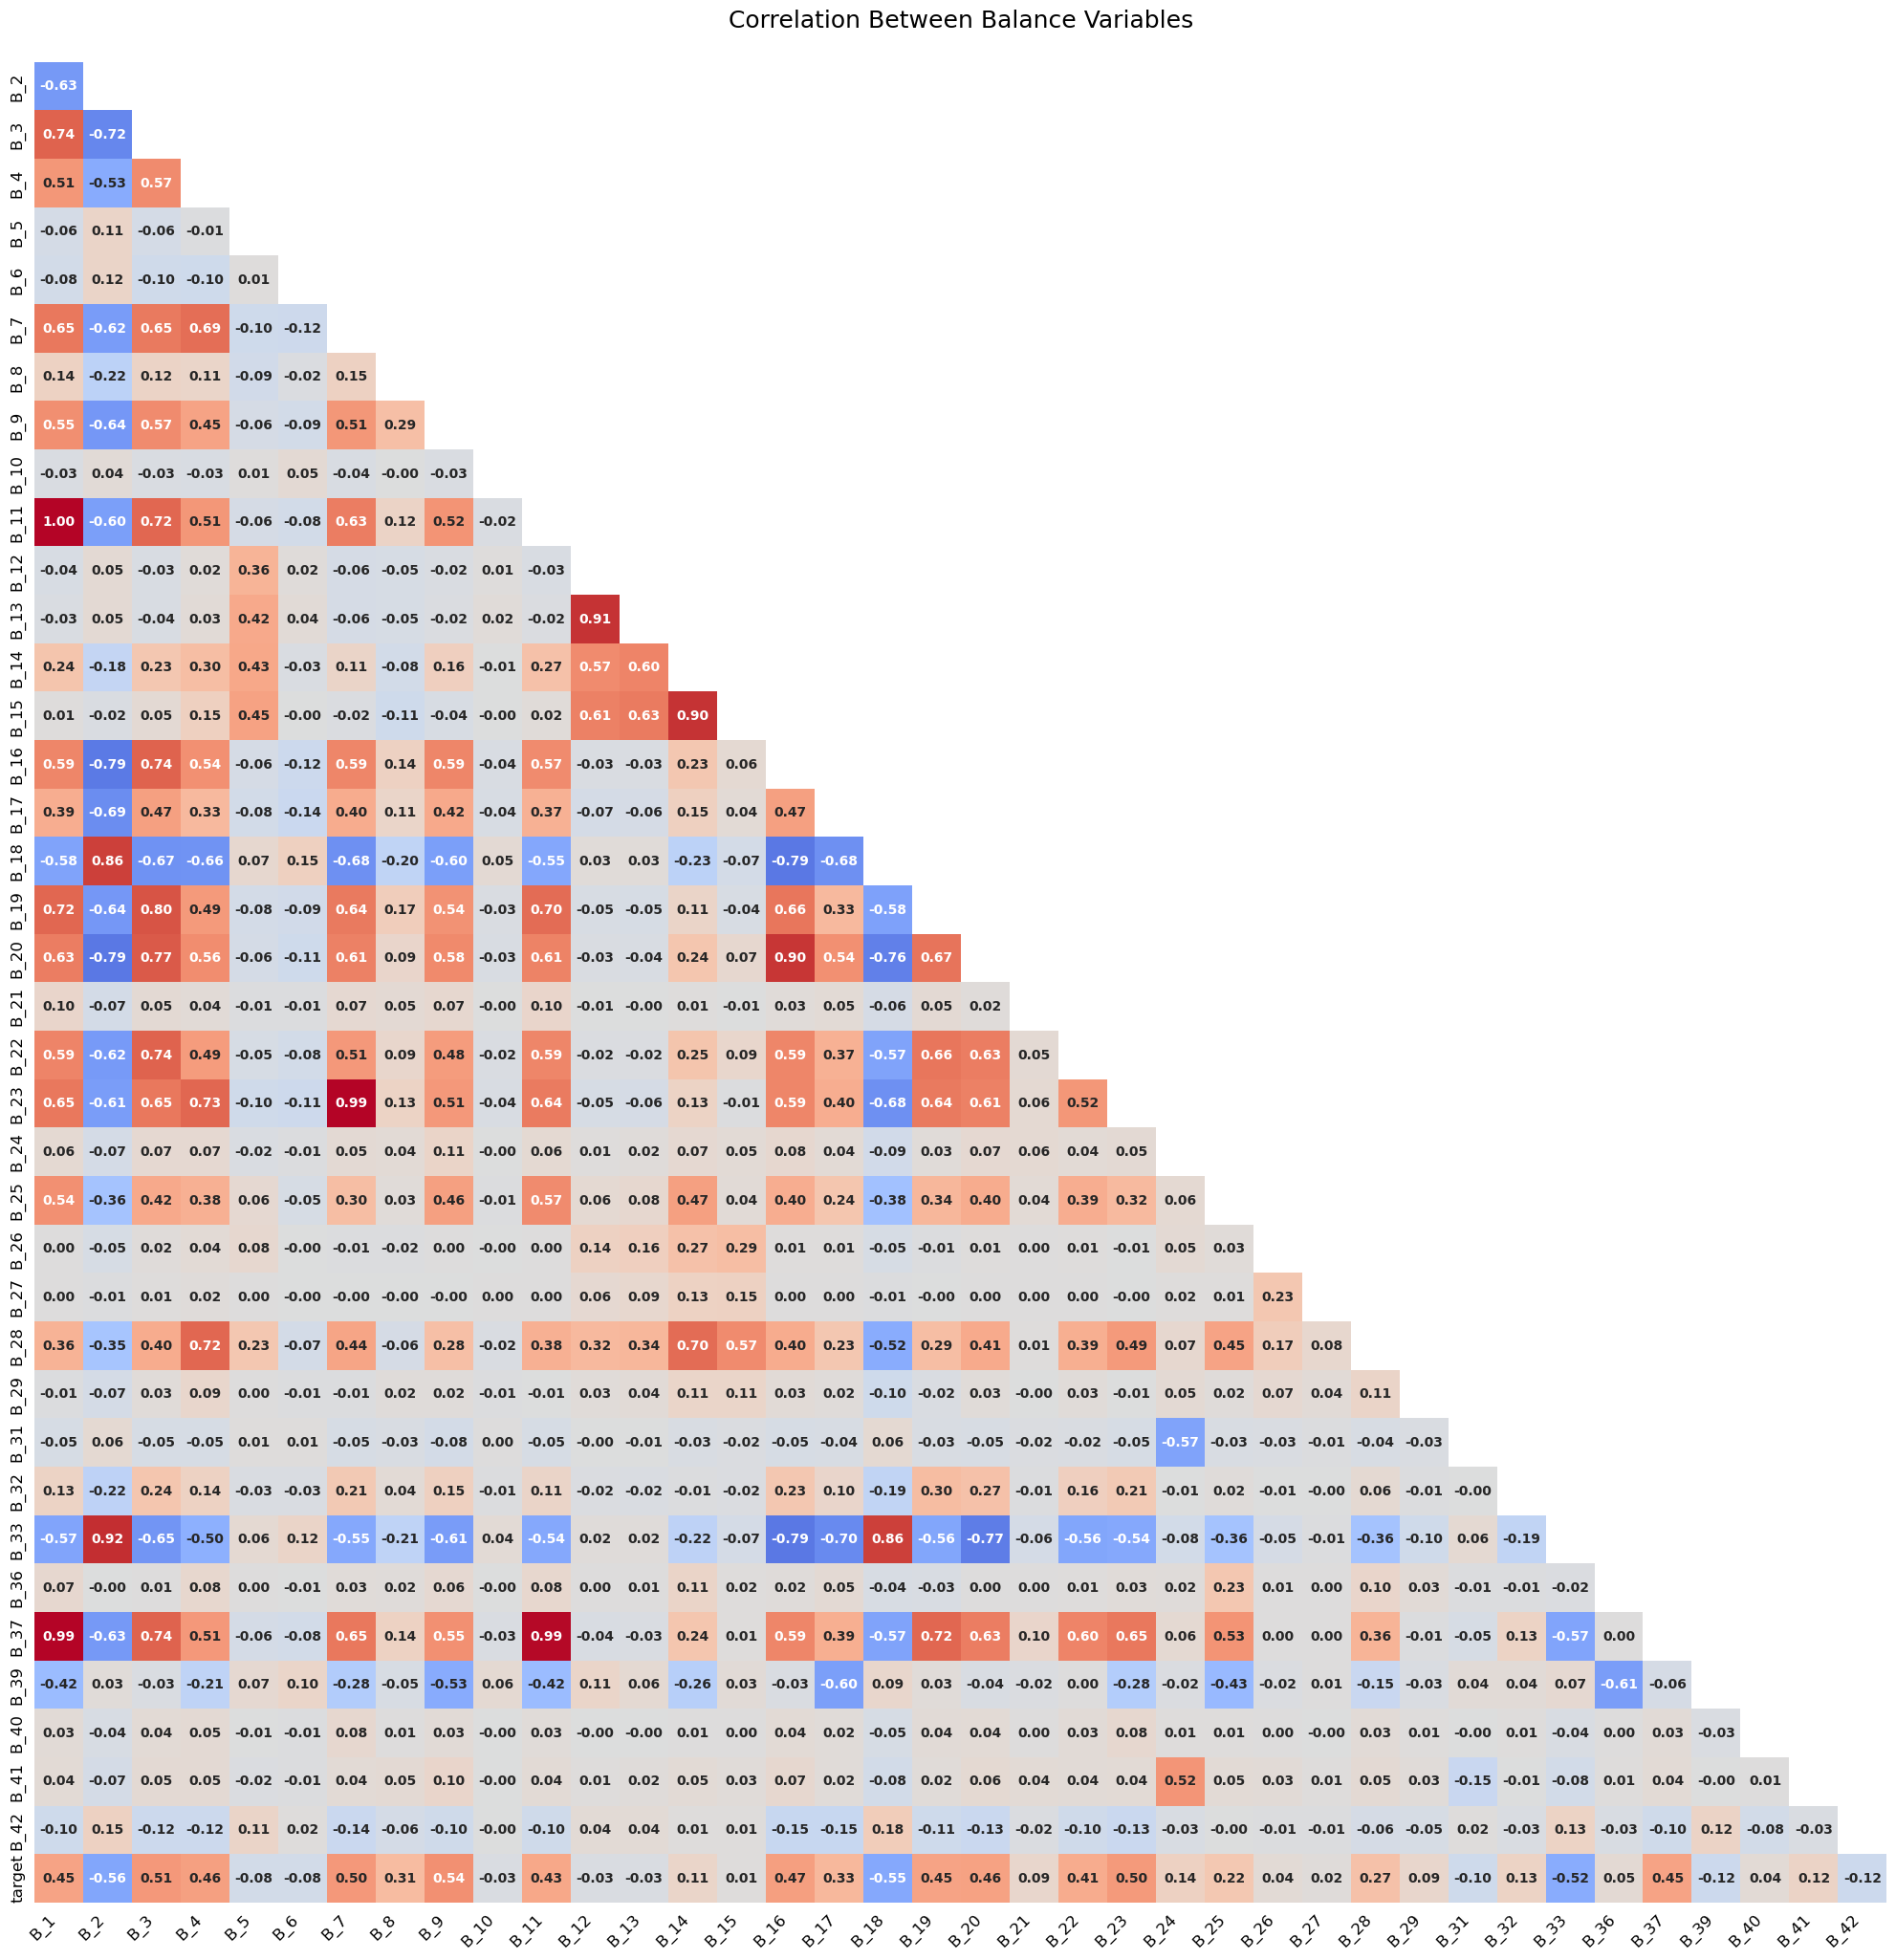

In [43]:
# Code modified from http://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols = [col for col in train.columns if (col.startswith(('B','t'))) & (col not in categoricalCols)]
corr = train[cols].corr()
mask = np.triu(np.ones_like(corr))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt=".2f",
            cmap='coolwarm', annot_kws={"fontsize" : 10, "fontweight": "bold"}, cbar=False)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlation Between Balance Variables\n', fontsize=18)

Text(0.5, 1.0, 'Correlation Between Risk Variables\n')

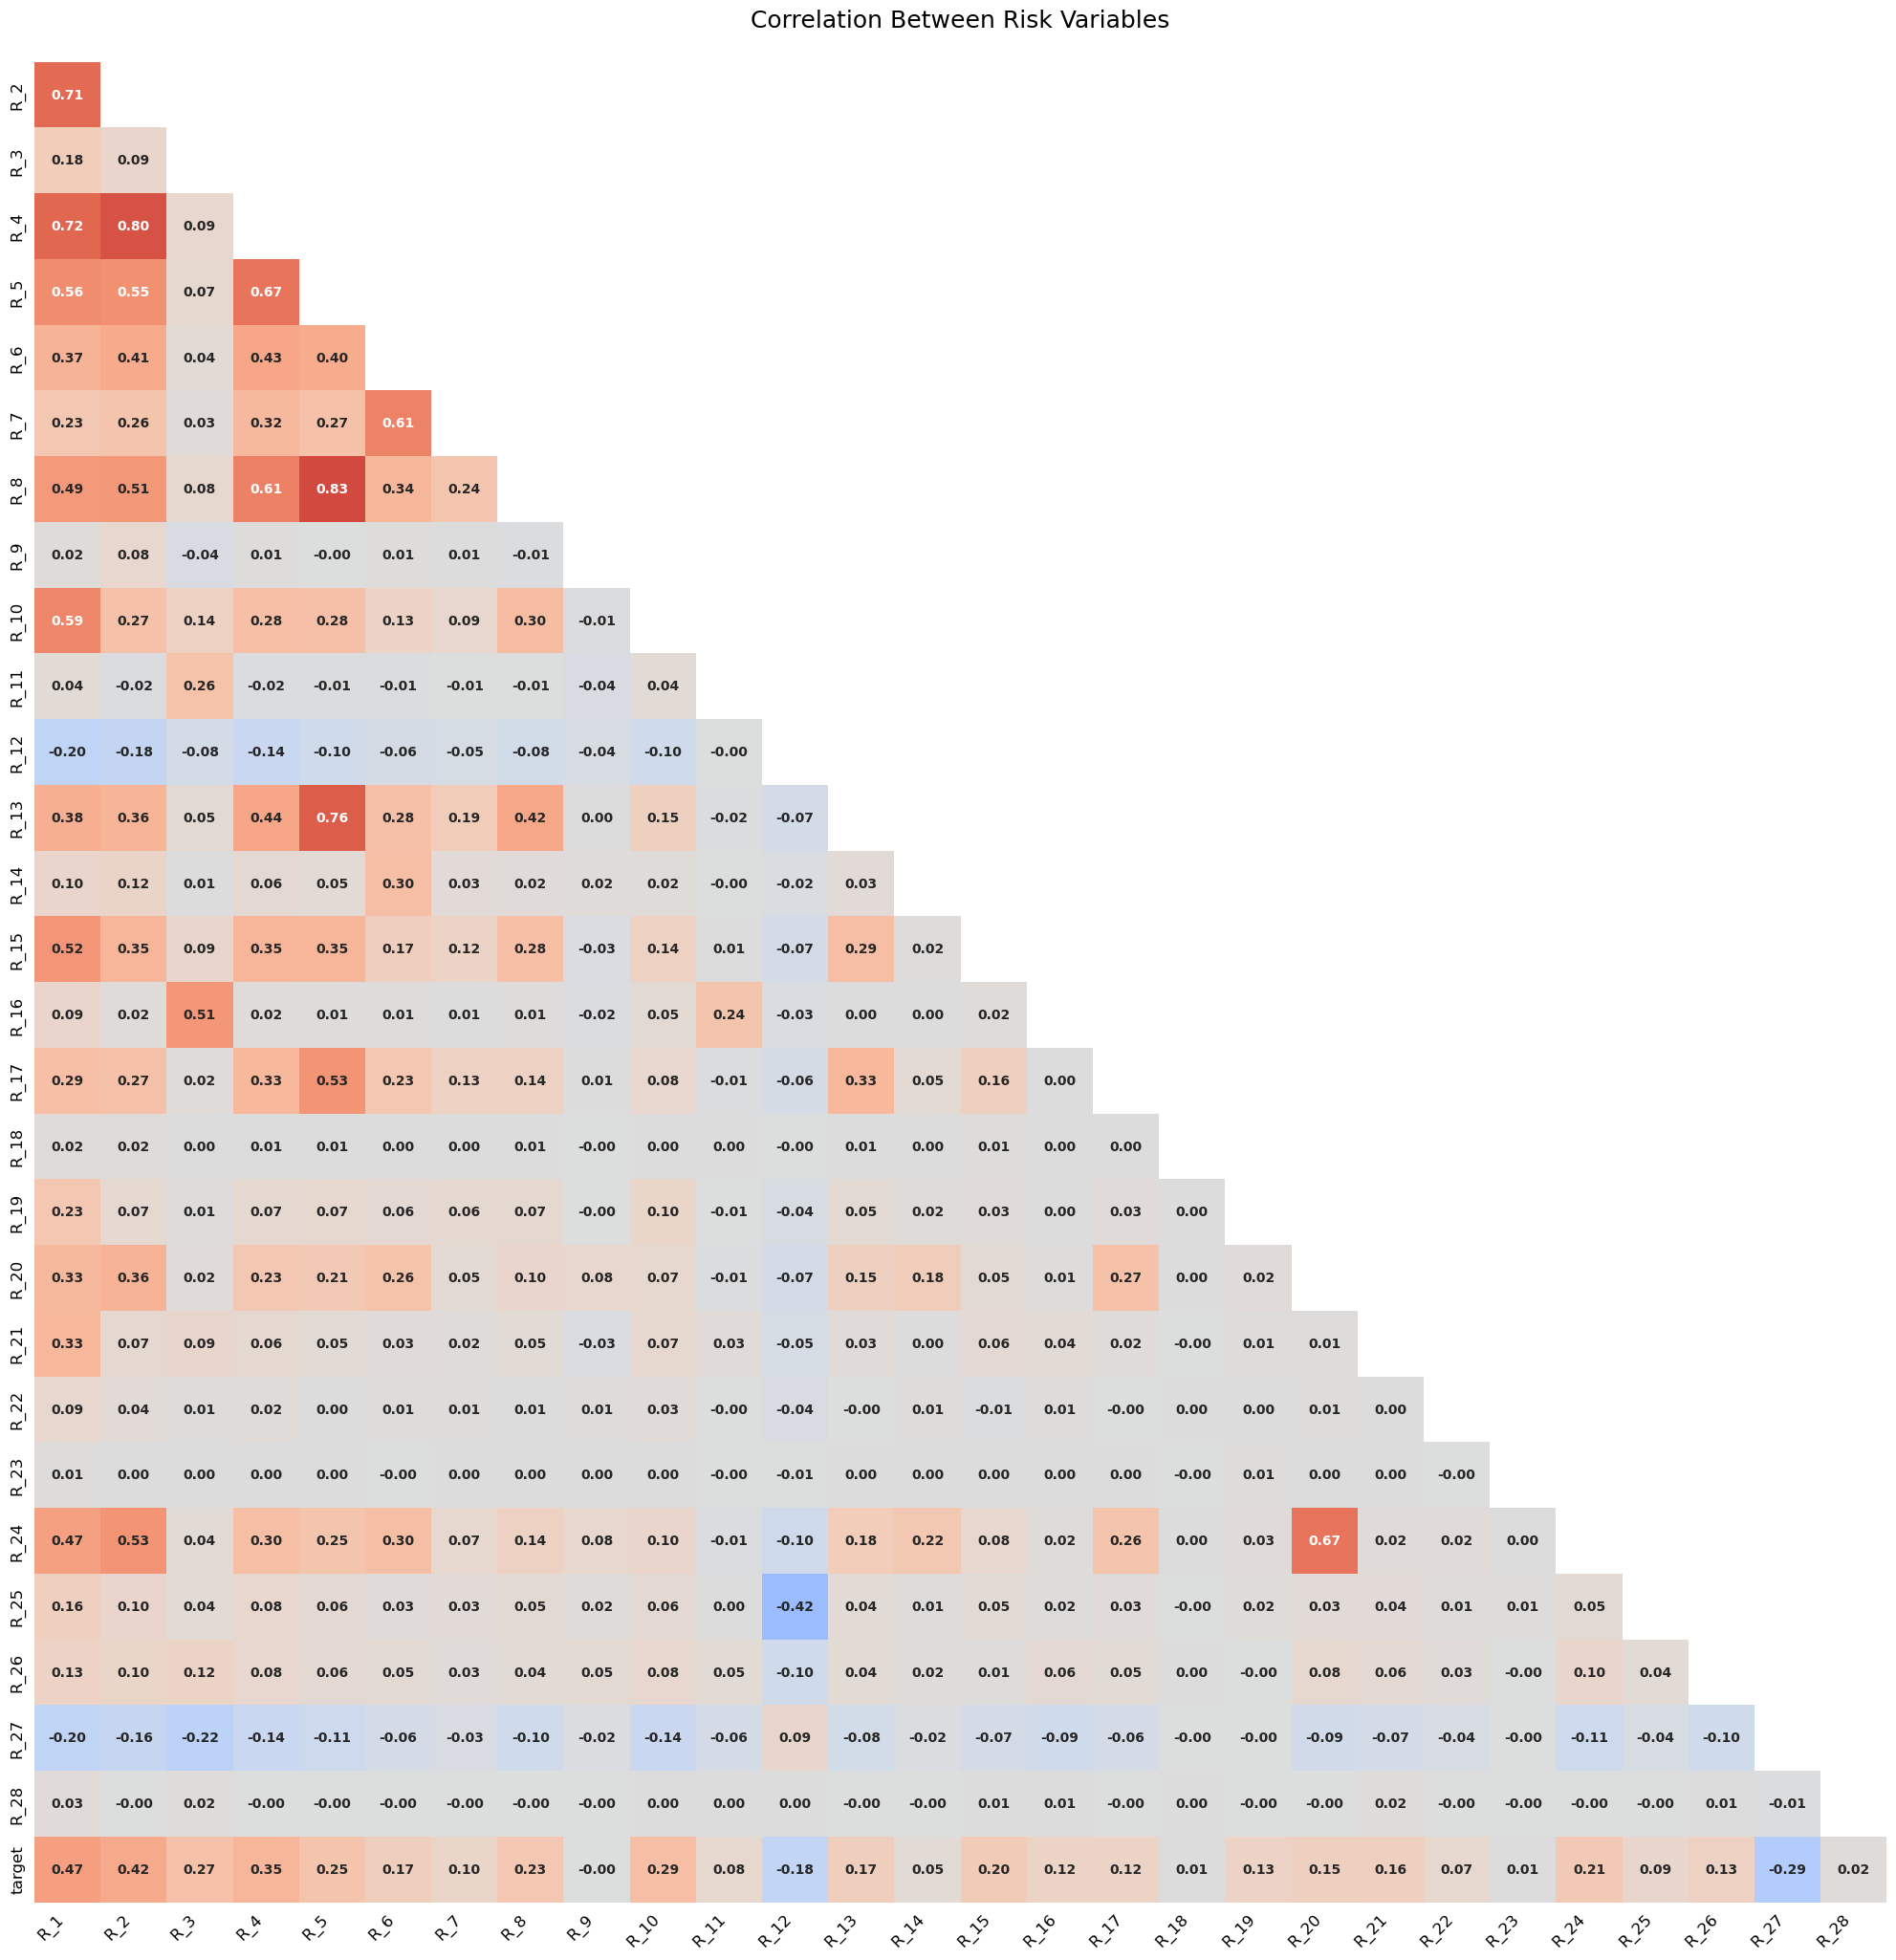

In [42]:
# Code modified from http://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols = [col for col in train.columns if (col.startswith(('R','t'))) & (col not in categoricalCols)]
corr = train[cols].corr()
mask = np.triu(np.ones_like(corr))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt=".2f",
            cmap='coolwarm', annot_kws={"fontsize" : 10, "fontweight": "bold"}, cbar=False)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlation Between Risk Variables\n', fontsize=18)